# PySP开发测试区

## 0. 测试准备

### 0.1 测试环境导入

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

### 0.2 测试数据生成

In [2]:
import numpy as np
fs = 1000.0
t = np.arange(0, 5, 1/fs)

# 多个谐波分量
harmonics = (
    2 * np.sin(2 * np.pi * 50 * t) +      # 50Hz
    1.5 * np.sin(2 * np.pi * 120 * t) +   # 120Hz
    np.sin(2 * np.pi * 250 * t)           # 250Hz
)

# 冲击序列
impulse = np.zeros_like(t)
impulse_indices = [200, 500, 700]
impulse[impulse_indices] = [5, -4, 6]

# 随机噪声冲击
random_impulse = np.zeros_like(t)
random_indices = np.random.choice(len(t), 5, replace=False)
random_impulse[random_indices] = np.random.uniform(-3, 3, size=5)

# 白噪声
white_noise = np.random.normal(0, 0.5, size=len(t))

# 合成信号
Data = harmonics + impulse + random_impulse + white_noise


## 1. Signal模块测试

### 1.1 Signal.Axis()

In [8]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Axis,t_Axis

# --------------------------------------------------------------------------------------------#
# 辅助接口


# --------------------------------------------------------------------------------------------#
# 测试过程

axis= Axis(N=10000,dx=0.1,x0=1.0,name="x",unit='u')
t_axis= t_Axis(len(axis),fs=1000.0)

print(axis)
print(t_axis)

ModuleNotFoundError: No module named 'PySP'

### 1.2 Signal.Series()

In [3]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Series

# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import t_Axis

# --------------------------------------------------------------------------------------------#
# 测试过程

Srs = Series(
    axis=t_Axis(len(Data), fs=fs), data=Data, name="位移", unit="μm", label="测试信号"
)
print(Srs)

Series[测试信号](位移=[-0.14997714  2.51118708  1.91077203 ... -2.35777797 -2.06237616
 -2.90201763]μm, t_Axis(时间=[0.000e+00 1.000e-03 2.000e-03 ... 4.997e+00 4.998e+00 4.999e+00]s))


### 1.1 Signal.Signal()

Signal[测试信号](位移=[-0.14997714  2.51118708  1.91077203 ... -2.35777797 -2.06237616
 -2.90201763]μm, t_Axis(时间=[0.000e+00 1.000e-03 2.000e-03 ... 4.997e+00 4.998e+00 4.999e+00]s))


f:\OneDrive\用户文件\科研学习\代码库\PySP.worktrees\dev\PySP\_Plot_Module\LinePlot.py:174: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


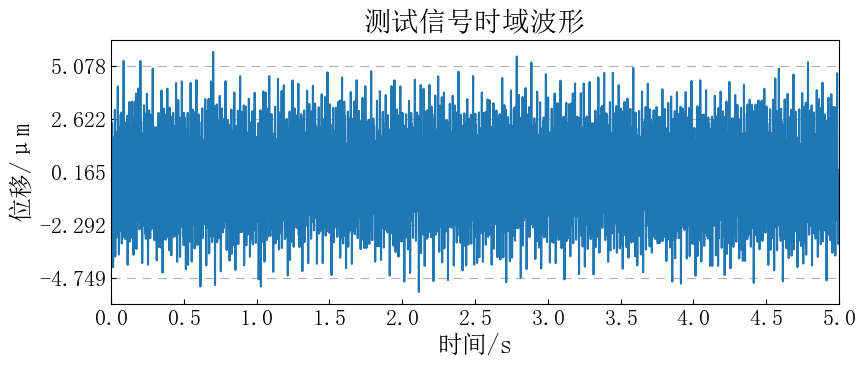

In [6]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Signal
# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import t_Axis
# --------------------------------------------------------------------------------------------#
# 测试过程

Sig = Signal(
    axis=t_Axis(len(Data), fs=fs), data=Data, name="位移", unit="μm", label="测试信号"
)
print(Sig)
Sig.plot()

### 1.4 Signal.Spectra()

Spectra[测试信号](幅值=[1.55898028e-16 5.39904893e-16 1.62631004e-16 ... 4.00932778e-16
 3.02099998e-16 5.26296821e-18]μm, f_Axis(频率=[0.000e+00 1.000e+00 2.000e+00 ... 2.498e+03 2.499e+03 2.500e+03]Hz))


f:\OneDrive\用户文件\科研学习\代码库\PySP.worktrees\dev\PySP\_Plot_Module\LinePlot.py:206: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


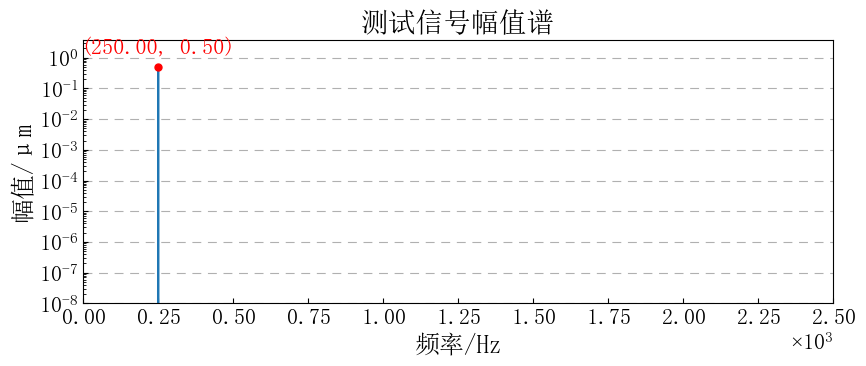

In [16]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Spectra

# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import f_Axis

# --------------------------------------------------------------------------------------------#
# 测试过程
_Data=np.abs(np.fft.rfft(np.sin(2*np.pi*50*t)))/len(t)
Spc = Spectra(
    axis=f_Axis(len(_Data), df=1.0), data=_Data, name="幅值", unit="μm", label="测试信号"
)
print(Spc)
Spc.plot()

### 1.2 Signal.Resample()

Signal[重采样测试信号](位移=[ 0.03999988  2.54333124  0.76637784  2.95470624 -0.2523092   2.63620112
 -3.72038394 -0.52988584 -5.12440861  0.59615521  0.32935027  1.45324989
 -0.05783941  3.35388479 -0.37887344  2.86962453 -3.39689288 -0.35608761
 -1.05671924  0.36095055 -2.77958788  1.60202225  2.57657231  3.75701074
 -0.83109023  0.26084522 -1.32206968  1.039967   -4.59033988 -1.47100968
 -0.34695584  2.2472808   0.24785797  1.7507574   0.85551486  3.47085326
 -3.15243311 -1.81830832 -2.10895077  0.93395189 -0.98559004  0.68359058
 -0.33639278  4.65621585 -2.41382896  1.32393753 -1.87646768  1.36715411
 -2.73831876 -1.51242856 -2.55423754  3.00111737 -0.21047696  2.6921188
 -0.01862294  2.10231199 -3.31865127 -0.033973   -3.54271475  0.62028516
 -0.26659701  1.7479281  -0.66501625  3.00407492 -0.84808649  2.24499295
 -3.72287538 -0.77005758 -1.66836646  0.48376196 -3.12719224  2.04648962
  1.23906354  4.44619713 -0.88147485  0.40184289 -1.58947105  1.47037789
 -3.51085255 -0.65601684 -0.44621

f:\OneDrive\用户文件\科研学习\代码库\PySP.worktrees\dev\PySP\_Plot_Module\LinePlot.py:174: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


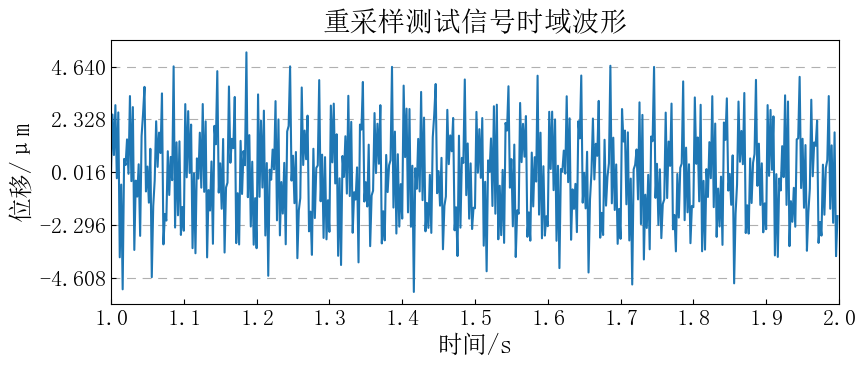

In [18]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Resample

# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import t_Axis,Signal

# --------------------------------------------------------------------------------------------#
# 测试过程
Sig= Signal(axis=t_Axis(len(Data), fs=fs), data=Data, name="位移", unit="μm", label="测试信号")
_Sig= Resample(Sig,type='extreme', dt=Sig.t_axis.dt*2, t0=1.0, T=1.0)
_Sig.label="重采样测试信号"
print(_Sig)
_Sig.plot()

### 1.3 Signal.Periodic()

Signal[仿真含噪准周期信号](=[0.67070187 0.51578729 2.07329058 ... 0.72570356 1.32149416 0.7843231 ], t_Axis(时间=[0.000e+00 1.000e-03 2.000e-03 ... 1.997e+00 1.998e+00 1.999e+00]s))


f:\OneDrive\用户文件\科研学习\代码库\PySP.worktrees\dev\PySP\_Plot_Module\LinePlot.py:174: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


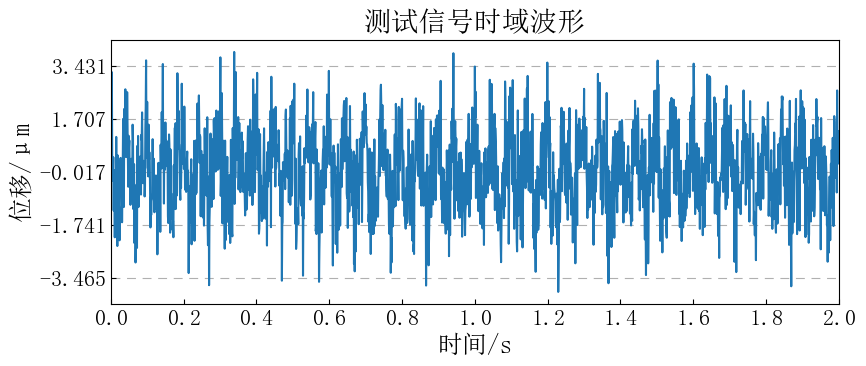

In [3]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Periodic

# --------------------------------------------------------------------------------------------#
# 辅助接口

# --------------------------------------------------------------------------------------------#
# 测试过程
Sig = Periodic(fs=1000.0, T=2.0, CosParams=((20, 1, 32), (50, 0.5, 0)), noise=1.0)
print(repr(Sig))
Sig.name, Sig.unit, Sig.label = '位移', 'μm', '测试信号'
Sig.plot()

### 1.3 Signal.Impulse()

Signal[仿真冲击信号](=[0. 0. 0. ... 0. 0. 0.], t_Axis(时间=[0.0000e+00 1.0000e-04 2.0000e-04 ... 1.9997e+00 1.9998e+00 1.9999e+00]s))


f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


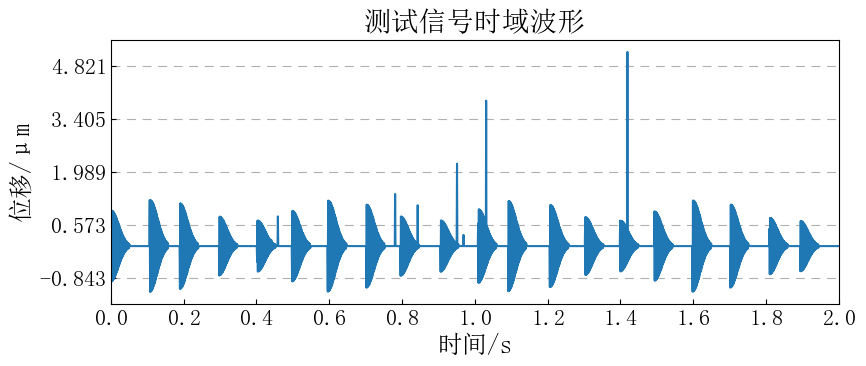

In [33]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Impulse

# --------------------------------------------------------------------------------------------#
# 辅助接口

# --------------------------------------------------------------------------------------------#
# 测试过程
Sig = Impulse(fs=10000.0, T=2.0, ImpParams=(1000, 10, 0.1, 0.3*np.sin(2 * np.pi * 2 * Sig.t_axis())+1, 0.05), noiseParams=(10, 1))
print(repr(Sig))
Sig.name, Sig.unit, Sig.label = '位移', 'μm', '测试信号'
Sig.plot()

### 1.3 Signal.Modulation()

Signal[仿真调制信号](=[ 1.          0.82054286  0.31290448 ... -0.28910451  0.3011331
  0.79631108], t_Axis(时间=[0.000e+00 1.000e-03 2.000e-03 ... 1.997e+00 1.998e+00 1.999e+00]s))


f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


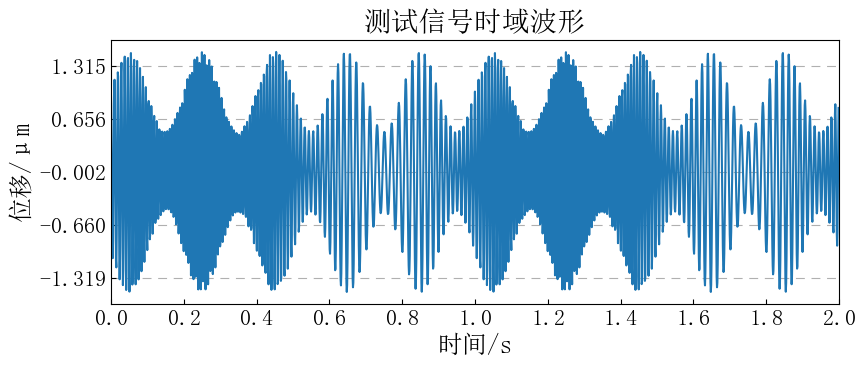

In [6]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Signal import Modulation

# --------------------------------------------------------------------------------------------#
# 辅助接口

# --------------------------------------------------------------------------------------------#
# 测试过程
Sig = Modulation(fs=1000.0, T=2.0, fc=100.0, AM=lambda t: 1 + 0.5 * np.sin(2 * np.pi * 5 * t), FM=lambda t: 50 * np.sin(2 * np.pi * 1 * t))
print(repr(Sig))
Sig.name, Sig.unit, Sig.label = '位移', 'μm', '测试信号'
Sig.plot()

## 2. Plot模块测试

### 2.1 Plot.Plot()

f:\OneDrive\用户文件\科研学习\代码库\PySP.worktrees\dev\PySP\_Plot_Module\core.py:387: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.figure.show()


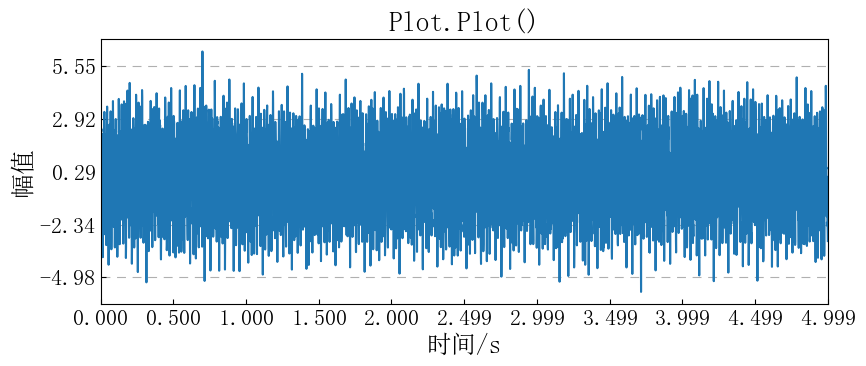

In [4]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Plot import Plot
# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import Signal, t_Axis
# --------------------------------------------------------------------------------------------#
# 测试过程
Sig = Signal(
    axis=t_Axis(len(Data), fs=fs), data=Data, name="位移", unit="um", label="测试信号"
)
class TestPlot(Plot):
    def plot(self, Sig: 'Signal', **kwargs):
        def _draw_plot(ax, data):
            ax.plot(data.__axis__(), data.data, label=data.label)
        task_kwargs = self.kwargs
        task_kwargs.update(kwargs)
        task = {
            "data": Sig,
            "kwargs": task_kwargs,
            "function": _draw_plot,
            "plugins": [], 
        }
        self.tasks.append(task)
        return self
test=TestPlot(xlabel="时间/s", ylabel="幅值", title="Plot.Plot()",).plot(Sig).show()

### 2.2 Plot.LinePlot()

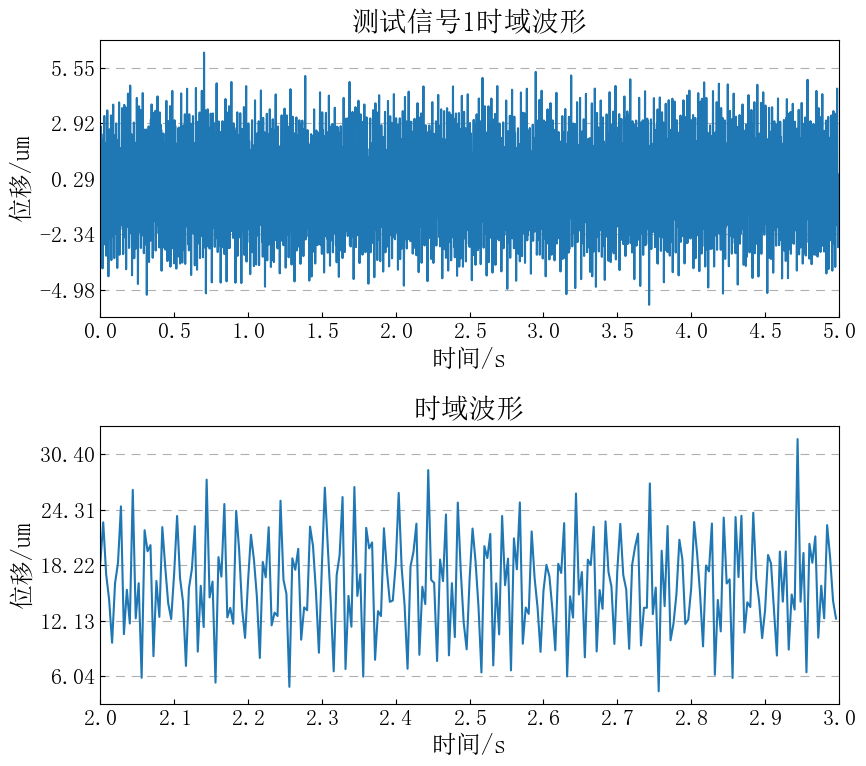

In [6]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Plot import LinePlot
# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import Signal, t_Axis, Resample
# --------------------------------------------------------------------------------------------#
# 测试过程
Sig1 = Signal(axis=t_Axis(len(Data), fs=fs), data=Data, name="位移", unit="um", label="测试信号1")
Sig2 = (Sig1 + 2) * 3 + 10
Sig2.label = "测试信号2"
Sig2 = Resample(Sig=Sig2, dt=Sig1.t_axis.dt*4, t0=2.0, T=1.0)
Plot = LinePlot(isSampled=True, title="Plot.LinePlot()")
Plot.timeWaveform(Sig1, ybins=7)
Plot.timeWaveform(Sig2)
Plot.show(pattern='return')
import matplotlib.pyplot as plt
plt.show()

### 2.3 Plot.PeakfinderPlugin()

f:\OneDrive\用户文件\科研学习\代码库\PySP.worktrees\dev\PySP\_Plot_Module\core.py:387: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.figure.show()


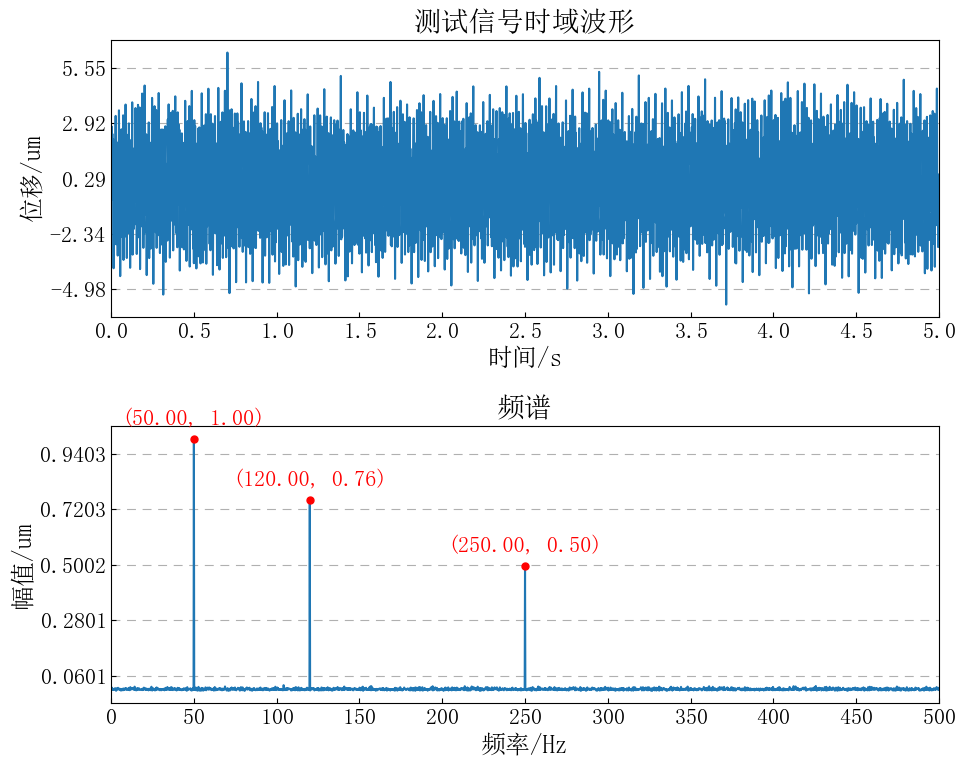

In [8]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Plot import PeakfinderPlugin
# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Plot import LinePlot
from PySP.Signal import Signal, t_Axis,f_Axis, Spectra
from scipy.fftpack import fft
# --------------------------------------------------------------------------------------------#
# 测试过程
Sig = Signal(axis=t_Axis(len(Data), fs=fs), data=Data, name="位移", unit="um", label="测试信号")
Plot = LinePlot(isSampled=True, figsize=(10, 4), title="Plot.PeakfinderPlugin()")
Plot.timeWaveform(Sig)
F_x = np.abs(fft(Sig.data)) / len(Sig)
Spc= Spectra(axis=Sig.f_axis, data=F_x, name="幅值", unit="um", label="测试信号")
Plot.spectrum(Spc)
Plot.set_params_to_task(xlim=(0,500), title="频谱")
Plot.add_plugin_to_task(PeakfinderPlugin(distance=50, prominence=0.1))
Plot.show()

## 3. Analysis模块测试

### 3.1 Analysis.Analysis()

f:\OneDrive\用户文件\科研学习\代码库\PySP.worktrees\dev\PySP\_Plot_Module\LinePlot.py:206: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
f:\OneDrive\用户文件\科研学习\代码库\PySP.worktrees\dev\PySP\_Plot_Module\LinePlot.py:174: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


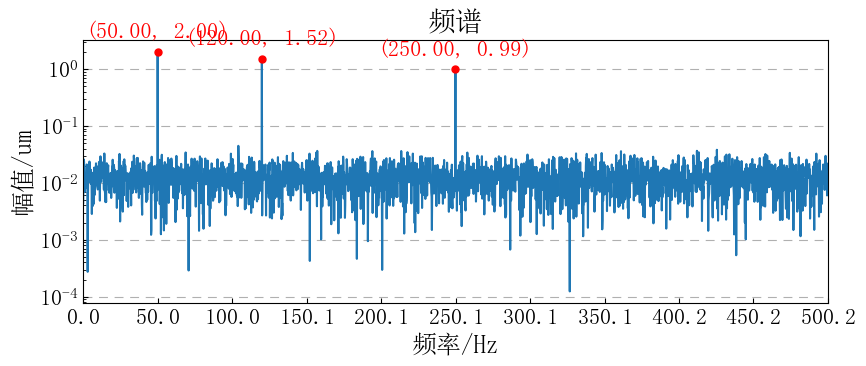

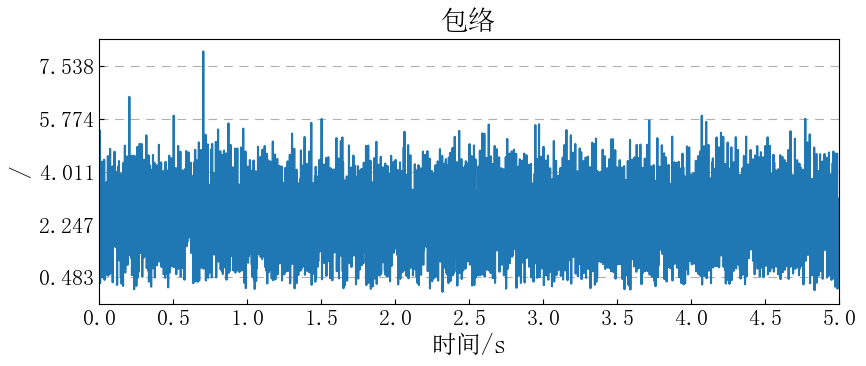

In [13]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Analysis import Analysis
# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import f_Axis, Signal, t_Axis
from PySP.Plot import TimeWaveformFunc, FreqSpectrumFunc
from scipy.signal import hilbert
# --------------------------------------------------------------------------------------------#
# 测试过程
class TestAnalysis(Analysis):
    @Analysis.Plot(TimeWaveformFunc)
    def envelope(self):
        """包络分析"""
        analytic_signal = hilbert(self.Sig.data)
        amplitude_envelope = np.abs(analytic_signal)
        return Signal(axis=t_Axis(len(amplitude_envelope), fs=self.Sig.t_axis.fs, t0=self.Sig.t_axis.t0), data=amplitude_envelope, label="包络信号")
    @Analysis.Plot(FreqSpectrumFunc)
    def fft(self):
        """FFT频谱分析"""
        N = len(self.Sig)
        Y = np.fft.fft(self.Sig.data)
        P2 = np.abs(Y / N)  # 双边频谱
        P1 = P2[: N // 2 + 1]  # 单边频谱
        P1[1:-1] = 2 * P1[1:-1]
        f = self.Sig.t_axis.fs * np.arange(0, (N / 2 + 1)) / N
        f = f_Axis(len(P1), df=self.Sig.f_axis.df)
        return Spectra(axis=f, data=P1, name="幅值", unit="um", label="测试信号")
Sig = Signal(axis=t_Axis(len(Data), fs=fs), data=Data, name="位移", unit="um", label="测试信号")
analysis = TestAnalysis(Sig, isPlot=True, title="频谱")
analysis.fft()
analysis.plot_kwargs['title'] = "包络"
res=analysis.envelope()

### 3.2 Analysis.window()

Signal[汉宁窗](=[0. 0. 0. ... 0. 0. 0.], t_Axis(时间=[0.000e+00 1.000e-03 2.000e-03 ... 1.097e+00 1.098e+00 1.099e+00]s))


f:\OneDrive\用户文件\科研学习\代码库\PySP.worktrees\dev\PySP\_Plot_Module\LinePlot.py:174: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


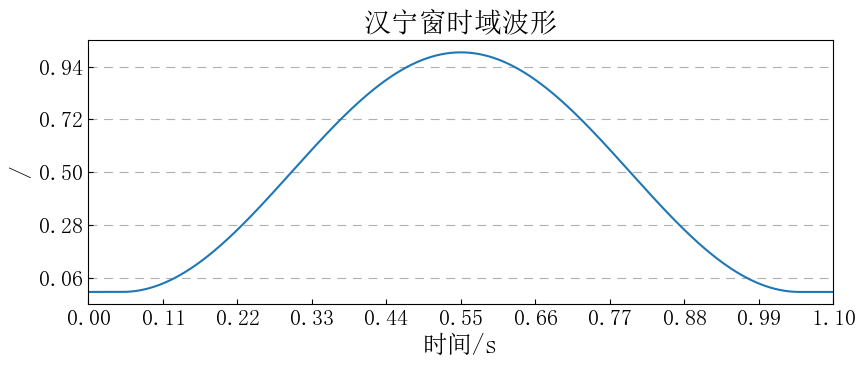

In [14]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Analysis import window
# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import Signal, t_Axis
# --------------------------------------------------------------------------------------------#
# 测试过程
data = window(type="汉宁窗", num=1000, padding=50)
res = Signal(axis=t_Axis(len(data), fs=fs), data=data, label="汉宁窗")
print(res)
res.plot()

### 3.3 Analysis.SpectrumAnalysis()

f:\OneDrive\用户文件\科研学习\代码库\PySP.worktrees\dev\PySP\_Plot_Module\LinePlot.py:206: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
f:\OneDrive\用户文件\科研学习\代码库\PySP.worktrees\dev\PySP\_Plot_Module\LinePlot.py:206: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Spectra[测试信号](功率密度=[3.51389622e-05 1.04244870e-03 1.33128422e-03 ... 1.42851003e-04
 4.56236919e-04 8.31528391e-04]μm^2/Hz, f_Axis(频率=[0.000e+00 2.000e-01 4.000e-01 ... 4.994e+02 4.996e+02 4.998e+02]Hz))

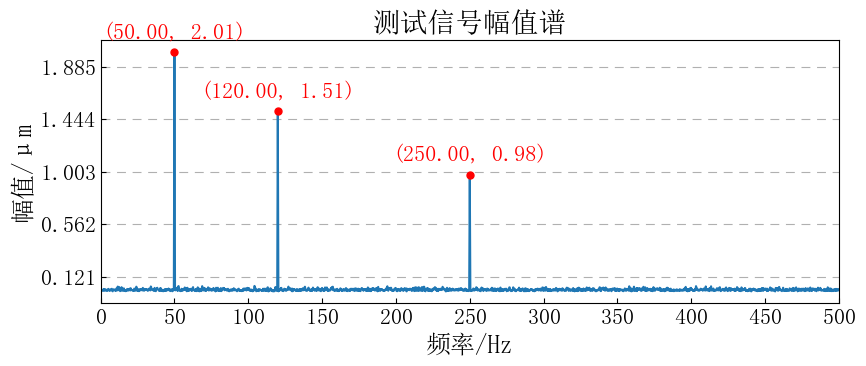

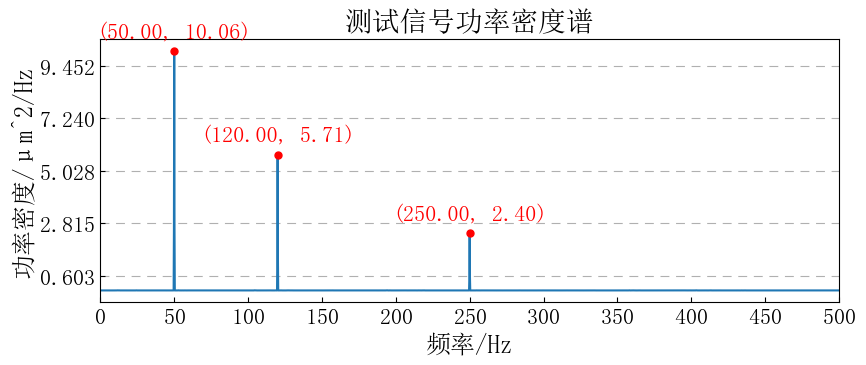

In [15]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Analysis import SpectrumAnalysis
# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import Signal, t_Axis
# --------------------------------------------------------------------------------------------#
# 测试过程
Sig = Signal(axis=t_Axis(len(Data), fs=fs), data=Data, name="位移", unit="μm", label="测试信号")
analysis = SpectrumAnalysis(Sig, isPlot=True, yscale='linear')
analysis.cft()
analysis.psd()

### 3.4 Analysis.EMDAnalysis()

f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


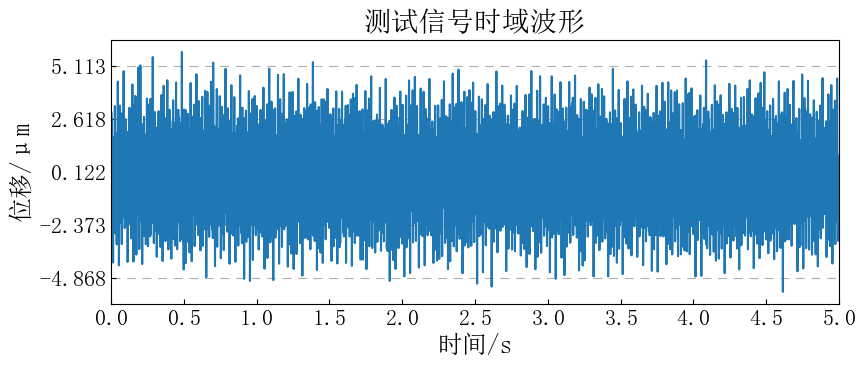

f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


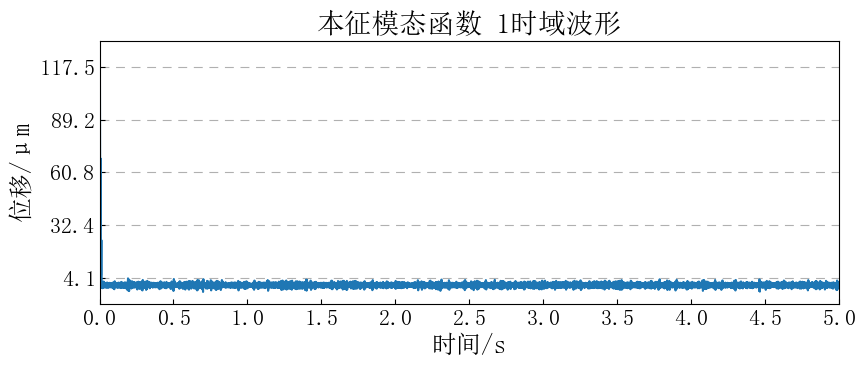

f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


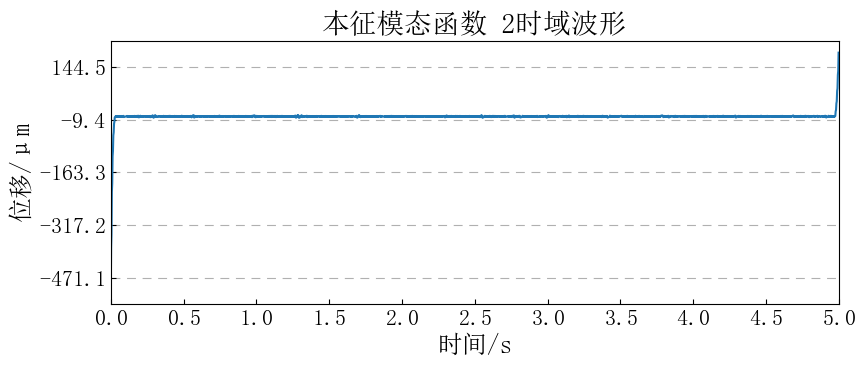

f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


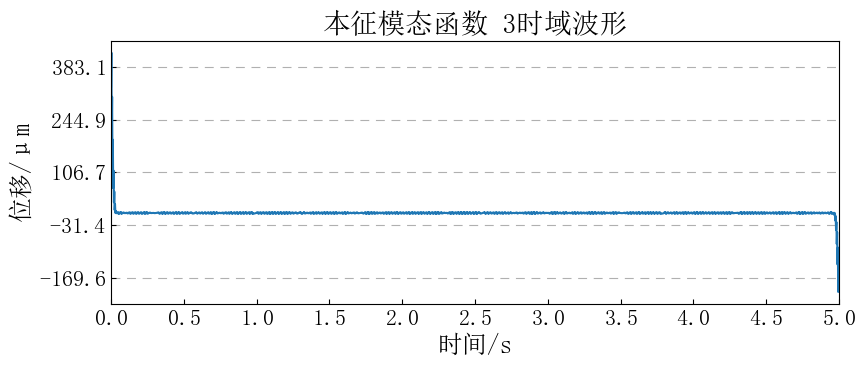

f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


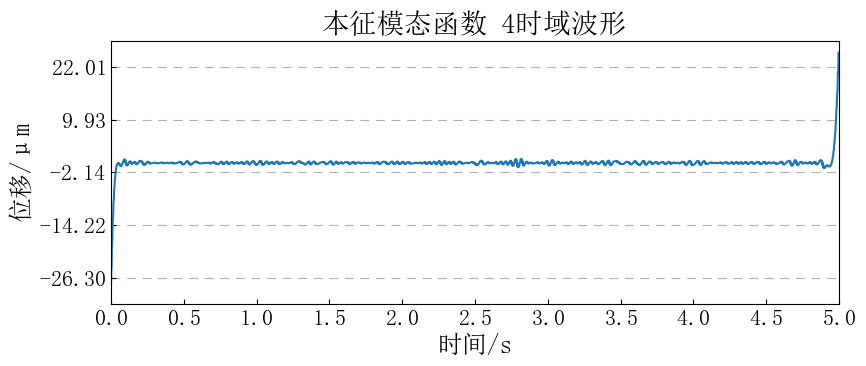

f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


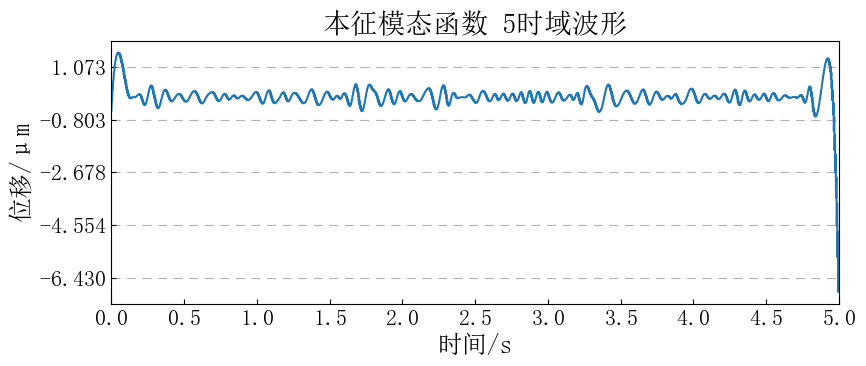

In [11]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Analysis import EMDAnalysis
# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import Signal, t_Axis
# --------------------------------------------------------------------------------------------#
# 测试过程
Sig = Signal(axis=t_Axis(len(Data), fs=fs), data=Data, name="位移", unit="μm", label="测试信号")
Sig.plot()
IMFs,res=EMDAnalysis(Sig,asy_toler=1e-2).emd()
for i, imf in enumerate(IMFs):
    Sig_imf = Signal(
        axis=t_Axis(len(imf), fs=fs),
        data=imf,
        name=Sig.name,
        unit=Sig.unit,
        label=f"本征模态函数 {i+1}"
    )
    Sig_imf.plot()


### 3.4 Analysis.VMDAnalysis()

f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


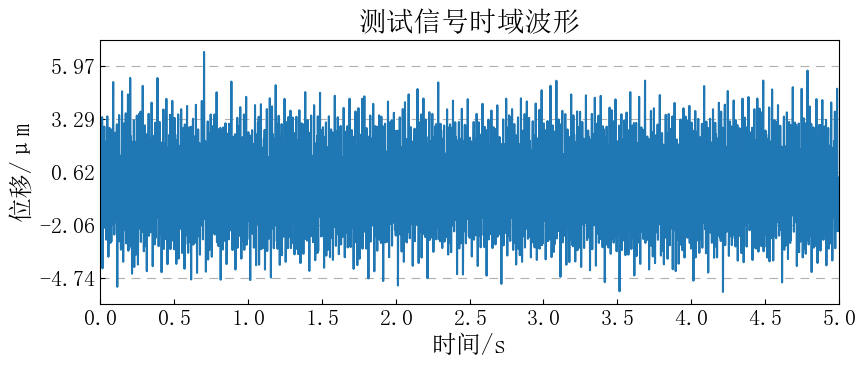

f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


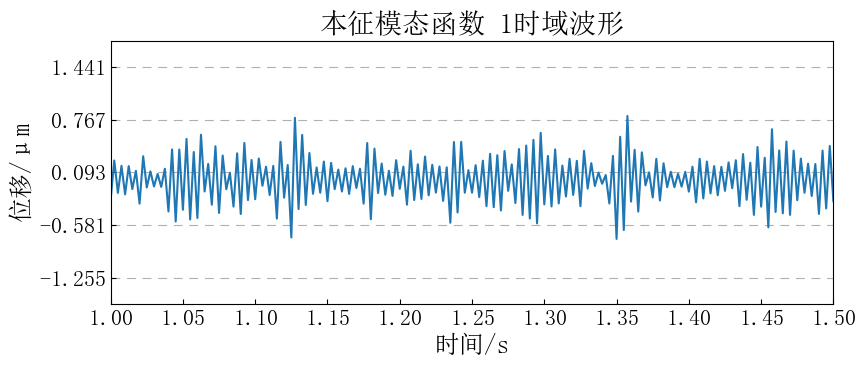

f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


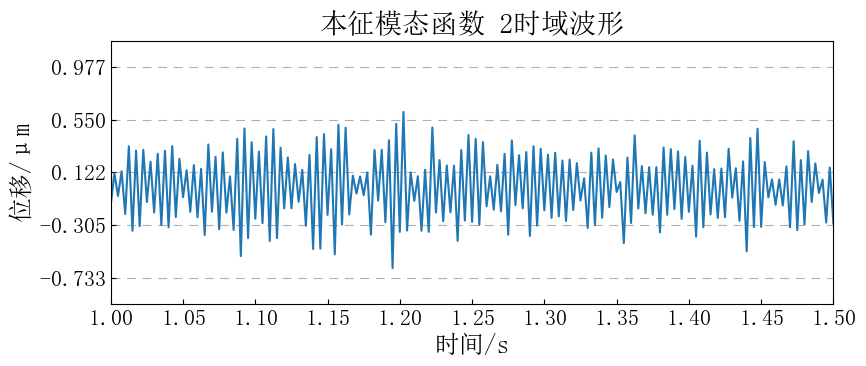

f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


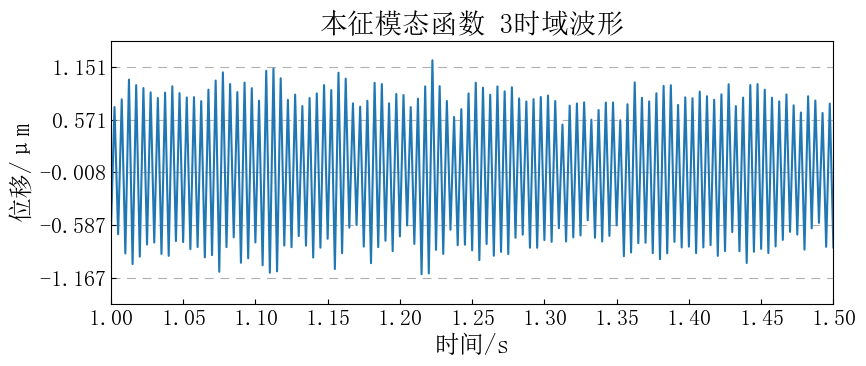

f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


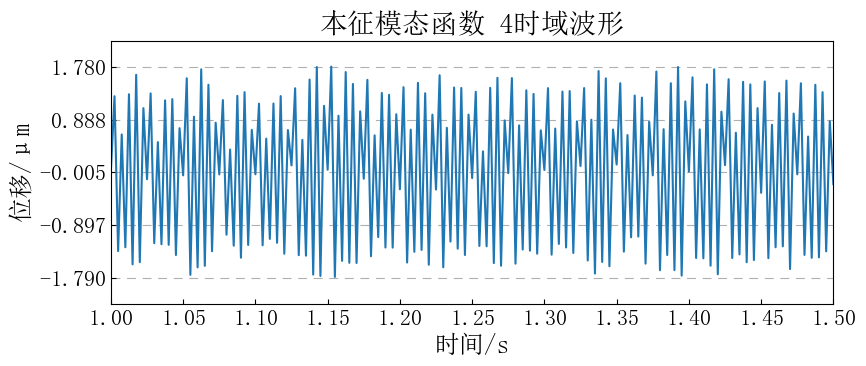

f:\OneDrive\用户文件\科研学习\代码库\PySP\PySP\_Plot_Module\LinePlot.py:167: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


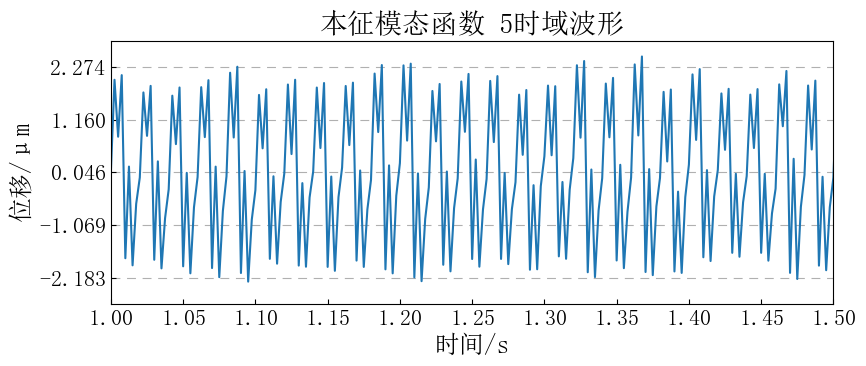

In [4]:
# --------------------------------------------------------------------------------------------#
# 测试接口
from PySP.Analysis import VMDAnalysis
# --------------------------------------------------------------------------------------------#
# 辅助接口
from PySP.Signal import Signal, t_Axis
# --------------------------------------------------------------------------------------------#
# 测试过程
Sig = Signal(axis=t_Axis(len(Data), fs=fs), data=Data, name="位移", unit="μm", label="测试信号")
Sig.plot()
IMFs,fc_list=VMDAnalysis(Sig,asy_toler=1e-2).vmd(k_num=5)
for i, imf in enumerate(IMFs):
    Sig_imf = Signal(
        axis=t_Axis(len(imf), fs=fs),
        data=imf,
        name=Sig.name,
        unit=Sig.unit,
        label=f"本征模态函数 {i+1}"
    )
    Sig_imf.plot(xlim=(1,1.5))
